In [2]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pint

ureg = pint.UnitRegistry()
ureg.setup_matplotlib()
ureg.define("neutron = 1 * particle = n")

SPECIFIC_ACT = 3.57e14 * ureg.Bq * ureg.g**-1
MOLAR_MASS = 6.032 / 2 * ureg.g * ureg.mol**-1


## Model definition

$$ V \frac{d c_\mathrm{salt}}{dt} = S - Q_\mathrm{sweep} - Q_\mathrm{top} $$

$$ S = \mathrm{TBR} \cdot \Gamma_n $$
where $\Gamma_n$ is the neutron rate in n/s.
$\mathrm{TBR}$ is assumed to evolve proportionally to the radius (see Figure 7 of [LIBRA paper](https://www.tandfonline.com/doi/full/10.1080/15361055.2022.2078136)) with $ \mathrm{TBR}(r= 7 \mathrm{cm}) = 0.01 $.

$Q_i$ are the release rate of T permeating through the walls and being released at the top of the salt and are expressed as:
$$ Q_i = A_i \ K_i \ (c_\mathrm{salt} - c_\mathrm{external}) \approx A_i \ K_i \ c_\mathrm{salt}$$
where $A_i$ is the contact surface area, $K_i$ are the mass transfer coefficients.


In [3]:
# BABY standard geometry
volume = 1 * ureg.L
radius = 7 * ureg.cm
cross_section = np.pi * radius**2
height = volume / cross_section
HEIGHT_TO_RADIUS = height / radius


class Model:
    def __init__(self) -> None:
        self.radius = 7 * ureg.cm

        self.L_wall = 1 * ureg.cm

        self.neutron_rate = 3e8 * ureg.neutron * ureg.s**-1

        self.c_old = 0 * ureg.particle * ureg.m**-3
        self.dt = 1 * ureg.h
        self.exposure_time = 300 * ureg.h

        self.concentrations = []
        self.times = []

    @property
    def volume(self):
        return self.A_top * self.height

    @property
    def height(self):
        return HEIGHT_TO_RADIUS * self.radius

    @property
    def A_top(self):
        return np.pi * self.radius**2

    @property
    def A_sweep(self):
        perimeter_sweep = 2 * np.pi * (self.radius + self.L_wall)
        return perimeter_sweep * self.height

    @property
    def TBR(self):
        ratio = 0.01 * ureg.particle * ureg.neutron**-1 / (7 * ureg.cm)
        return ratio * self.radius

    def source(self, t):
        if t < self.exposure_time:
            S_current = self.TBR * self.neutron_rate
        else:
            S_current = 0 * self.TBR * self.neutron_rate
        return S_current

    def Q_sweep(self, c_salt, t):
        K_sweep = 1.9e-8 * ureg.m * ureg.s**-1  # from Kumagai
        return self.A_sweep * K_sweep * c_salt

    def Q_top(self, c_salt):
        K_top = 4.9e-7 * ureg.m * ureg.s**-1  # from Kumagai
        return self.A_top * K_top * c_salt

    def equation(self, c, t):
        c *= ureg.particle * ureg.m**-3

        lhs = self.volume * (c - self.c_old) / self.dt
        rhs = self.source(t) - self.Q_sweep(c, t) - self.Q_top(c)
        return lhs - rhs

    def run(self):
        t = 0 * ureg.s
        while t < self.exposure_time * 2:
            t += self.dt
            c_new = (
                fsolve(self.equation, x0=self.c_old, args=(t,))
                * ureg.particle
                * ureg.m**-3
            )
            self.c_old = c_new

            self.times.append(t)
            self.concentrations.append(c_new)
        self.concentrations = ureg.Quantity.from_list(self.concentrations)
        self.times = ureg.Quantity.from_list(self.times)


## Standard BABY run

In [4]:
baby_model = Model()
baby_model.run()


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


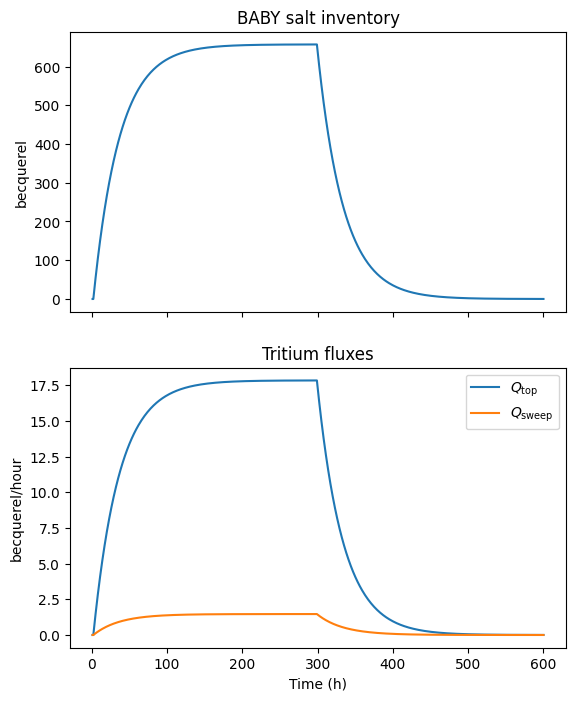

In [5]:
time = baby_model.times.to(ureg.h)

fig, (ax_inv, ax_fluxes) = plt.subplots(2, 1, sharex=True, figsize=(6.4, 8))
plt.sca(ax_inv)
plt.title("BABY salt inventory")
inventory = baby_model.concentrations * baby_model.volume * SPECIFIC_ACT * MOLAR_MASS
plt.plot(time, inventory.to(ureg.Bq))

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = baby_model.Q_top(baby_model.concentrations) * SPECIFIC_ACT * MOLAR_MASS
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = (
    baby_model.Q_sweep(baby_model.concentrations, baby_model.times)
    * SPECIFIC_ACT
    * MOLAR_MASS
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="$Q_\mathrm{top}$")
plt.plot(time, release_walls, label="$Q_\mathrm{sweep}$")
plt.xlabel(f"Time ({time.units:~P})")
plt.legend()
plt.show()


## Varying the volume of salt

In [7]:
radius_values = [1, 2, 3, 4, 5, 6, 7] * ureg.cm
models = []

for radius in radius_values:
    my_model = Model()
    my_model.radius = radius
    models.append(my_model)

    my_model.run()


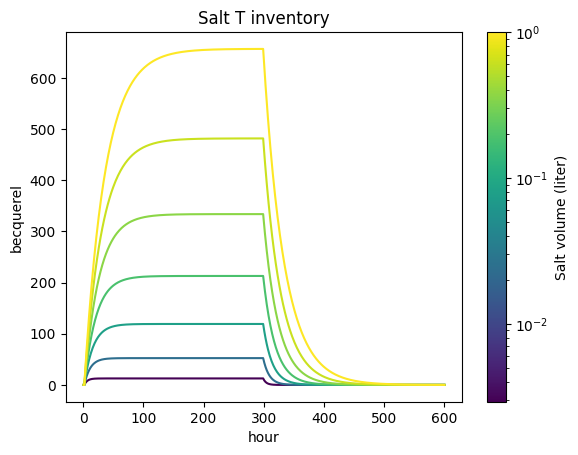

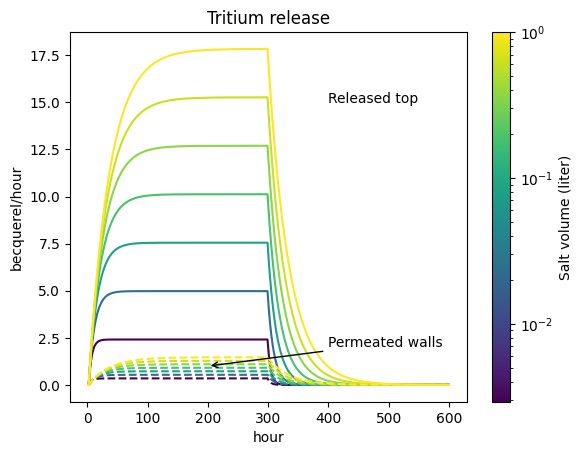

In [8]:
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

volume_values = [model.volume for model in models]
volume_values = ureg.Quantity.from_list(volume_values)
norm_V_salt = LogNorm()
norm_V_salt.autoscale(volume_values.magnitude)


for model in models:
    times = model.times.to(ureg.h)
    inventory = model.volume * model.concentrations * SPECIFIC_ACT * MOLAR_MASS
    colour = cm.viridis(norm_V_salt(model.volume.magnitude))

    plt.figure(1)
    plt.plot(times, inventory.to(ureg.Bq), color=colour)

    plt.figure(2)
    top_release = model.Q_top(model.concentrations)
    top_release *= SPECIFIC_ACT * MOLAR_MASS
    top_release = top_release.to(ureg.Bq * ureg.h**-1)
    wall_release = model.Q_sweep(model.concentrations, times)
    wall_release *= SPECIFIC_ACT * MOLAR_MASS
    wall_release = wall_release.to(ureg.Bq * ureg.h**-1)
    plt.plot(times, top_release, color=colour)
    plt.plot(times, wall_release, linestyle="dashed", color=colour)

sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm_V_salt)

plt.figure(1)
plt.title("Salt T inventory")
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")
plt.figure(2)
plt.title("Tritium release")
plt.annotate("Released top", (400 * ureg.h, 15 * ureg.Bq * ureg.h**-1))
plt.annotate(
    "Permeated walls",
    (200 * ureg.h, 1 * ureg.Bq * ureg.h**-1),
    (400 * ureg.h, 2 * ureg.Bq * ureg.h**-1),
    arrowprops=dict(facecolor="black", arrowstyle="->"),
)
plt.colorbar(sm, ax=plt.gca(), label=f"Salt volume ({model.volume.units})")
plt.show()


## Notes

- The expression of the permeated flux is taken from Kumagai's paper. However, since we're dealing with a salt behaving according to Henry's law, the flux should be proportional to the square root of the salt concentration. The steady-state flux can be expressed as:

$$Q = A \ \frac{c_\mathrm{inconel, 0} \ D_\mathrm{inconel}}{e} $$
with $c_\mathrm{metal, 0}$ the concentration at **the surface of the metal**, $D_\mathrm{inconel}$ the diffusivity of inconel, and $e$ is the wall thickness.

From the solubility law:
$$ c_\mathrm{inconel, 0} = \frac{K_\mathrm{S, inconel}}{\sqrt{K_\mathrm{S, salt}}} \ \sqrt{c_\mathrm{salt}} $$
with $K_\mathrm{S, i}$ the solubility of the materials.

Therefore:
$$Q = A \ K \ \sqrt{c_\mathrm{salt}} $$
with
$$ K = \frac{K_\mathrm{S, inconel}}{\sqrt{K_\mathrm{S, salt}}} \ \frac{D_\mathrm{inconel}}{e}$$